In [1]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [2]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [3]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/MIT-Cassandra'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [4]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

In [5]:
len(all_data)

47

In [6]:
df2 = pd.concat(all_data)
df2.head(5)

,forecast_date,target,target_end_date,location,type,quantile,value
351,2021-05-10,1 wk ahead inc case,2021-05-15,42,point,NaN,17508.990812
353,2021-05-10,2 wk ahead inc case,2021-05-22,42,point,NaN,23681.682677
355,2021-05-10,3 wk ahead inc case,2021-05-29,42,point,NaN,28473.168047
357,2021-05-10,4 wk ahead inc case,2021-06-05,42,point,NaN,30744.602252
359,2021-05-10,5 wk ahead inc case,2021-06-12,42,point,NaN,32981.435683


In [7]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [8]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

,forecast_date,target,target_end_date,location,type,quantile,value
351,2021-05-10,1 wk ahead inc case,2021-05-15,42,point,NaN,17508.990812
353,2021-05-10,2 wk ahead inc case,2021-05-22,42,point,NaN,23681.682677
526,2021-05-17,1 wk ahead inc case,2021-05-22,42,point,NaN,12943.000000
355,2021-05-10,3 wk ahead inc case,2021-05-29,42,point,NaN,28473.168047
529,2021-05-17,2 wk ahead inc case,2021-05-29,42,point,NaN,10053.915950
...,...,...,...,...,...,...,...
535,2022-03-07,4 wk ahead inc case,2022-04-02,42,point,NaN,5652.144363
532,2022-03-14,3 wk ahead inc case,2022-04-02,42,point,NaN,959.547599
538,2022-03-07,5 wk ahead inc case,2022-04-09,42,point,NaN,5668.496479
535,2022-03-14,4 wk ahead inc case,2022-04-09,42,point,NaN,963.272551


In [9]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(43, 7)

In [10]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [11]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2022-03-02')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
0,2021-05-15,2021-05-10,1 wk ahead inc case,42,point,NaN,17508.990812,2501.284402
1,2021-05-22,2021-05-17,1 wk ahead inc case,42,point,NaN,12943.000000,1849.000000
2,2021-05-29,2021-05-24,1 wk ahead inc case,42,point,NaN,10027.000000,1432.428571
3,2021-06-05,2021-05-31,1 wk ahead inc case,42,point,NaN,6933.000000,990.428571
4,2021-06-12,2021-06-07,1 wk ahead inc case,42,point,NaN,3923.000000,560.428571


In [14]:
df_weekly.tail(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
35,2022-01-29,2022-01-24,1 wk ahead inc case,42,point,NaN,116425.389164,16632.198452
36,2022-02-05,2022-01-31,1 wk ahead inc case,42,point,NaN,73992.260025,10570.322861
37,2022-02-12,2022-02-07,1 wk ahead inc case,42,point,NaN,119802.269718,17114.609960
38,2022-02-19,2022-02-14,1 wk ahead inc case,42,point,NaN,19167.246344,2738.178049
39,2022-02-26,2022-02-21,1 wk ahead inc case,42,point,NaN,18415.307480,2630.758211


In [12]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
#del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[2501.2844016659405, 2501.2844016659405, 2501.2844016659405, 2501.2844016659405, 2501.2844016659405, 2501.2844016659405, 2501.2844016659405, 1849.0, 1849.0, 1849.0, 1849.0, 1849.0, 1849.0, 1849.0, 1432.4285714285713, 1432.4285714285713, 1432.4285714285713, 1432.4285714285713, 1432.4285714285713, 1432.4285714285713, 1432.4285714285713, 990.4285714285714, 990.4285714285714, 990.4285714285714, 990.4285714285714, 990.4285714285714, 990.4285714285714, 990.4285714285714, 560.4285714285714, 560.4285714285714, 560.4285714285714, 560.4285714285714, 560.4285714285714, 560.4285714285714, 560.4285714285714, 366.8442518480755, 366.8442518480755, 366.8442518480755, 366.8442518480755, 366.8442518480755, 366.8442518480755, 366.8442518480755, 234.0961136242035, 234.0961136242035, 234.0961136242035, 234.0961136242035, 234.0961136242035, 234.0961136242035, 234.0961136242035, 144.81568228105905, 144.81568228105905, 144.81568228105905, 144.81568228105905, 144.81568228105905, 144.81568228105905, 144.8156822

In [13]:
len(predictions)

280

In [19]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2021-05-15') & (df1['Date'] <= '2022-02-18')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2021-05-15,2140,3686.1,2398022,25603978,580.5,1090.7,637395.5,2860489,-5275.682283,2774.207671
1,2021-05-16,1630,3630.0,2399652,25603978,444.6,1076.0,637840.2,2860489,-5275.682283,2774.207671
2,2021-05-17,3930,3428.7,2403582,25603978,1207.7,1007.3,639047.1,2860489,-5275.682283,2774.207671
3,2021-05-18,2554,3175.9,2406136,25603978,716.0,940.4,639763.1,2860489,-5275.682283,2774.207671
4,2021-05-19,2854,2974.2,2408990,25603978,922.1,892.8,640685.2,2860489,-5275.682283,2774.207671


In [53]:
df1_copy.tail(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Prediction,Error,Accuracy,RawError
275,2022-02-14,5636,7016.0,5461544,25603978,1863.7,2352.3,1499856.1,2860489,-5275.682283,2774.207671,2630.758211,0.533222,0.466778,-0.533222
276,2022-02-15,4890,6428.4,5466434,25603978,1790.6,2126.4,1501646.4,2860489,-5275.682283,2774.207671,2630.758211,0.462013,0.537987,-0.462013
277,2022-02-16,7384,6172.4,5473818,25603978,2262.0,2015.2,1503908.7,2860489,-5275.682283,2774.207671,2630.758211,0.643722,0.356278,-0.643722
278,2022-02-17,5988,5874.2,5479806,25603978,1984.3,1922.5,1505893.0,2860489,-5275.682283,2774.207671,2630.758211,0.560662,0.439338,-0.560662
279,2022-02-18,7464,5581.8,5487270,25603978,2514.5,1838.3,1508407.1,2860489,-5275.682283,2774.207671,2630.758211,0.647540,0.352460,-0.647540


In [20]:
len(df1_copy)

280

In [21]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [ ]:
df1_copy.head(20)

In [23]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [24]:
merged_df_new.shape

(280, 12)

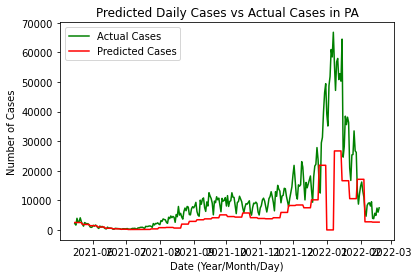

In [25]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [26]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['New Cases'] - row["Prediction"]) / row['New Cases'])
  error.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

249
0.8892857142857142
31
0.11071428571428577
280
[0.1688244867597853, 0.5345303077705157, 0.3635408647160457, 0.020640406552098454, 0.12358640446182882, 0.3890365408729994, 0.0976607497597617, 0.03697916666666667, 0.45361635220125784, 0.25623491552695093, 0.17602495543672014, 0.09184675834970531, 0.1327392120075047, 0.09928656361474435, 0.3853274385189278, 0.7012215812690871, 0.40434173669467777, 0.08177655677655683, 0.12435523660013448, 0.13291248702870984, 0.07378453630327686, 0.25370705244122965, 1.0379188712522047, 0.2508104603414739, 0.1004761904761905, 0.16910354745925216, 0.06957729095958039, 0.3384169884169884, 0.38036593947924, 0.5481452249408051, 0.40506521079769486, 0.006332320162107367, 0.1610350727117194, 0.07824248120300749, 0.0945870535714286, 0.3791137287521635, 0.5677104779832286, 0.31813336087718314, 0.2603946535321059, 0.1919730135504945, 0.1428872620372068, 0.10087193174491302, 0.16394245134213037, 0.2585812560441048, 0.4205541741975161, 0.3903747041036367, 0.39353

In [27]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.8311755132402147, 0.4654696922294843, 0.6364591352839544, 0.9793595934479016, 0.8764135955381712, 0.6109634591270006, 0.9023392502402383, 0.9630208333333333, 0.5463836477987422, 0.743765084473049, 0.8239750445632799, 0.9081532416502947, 0.8672607879924953, 0.9007134363852557, 0.6146725614810722, 0.29877841873091293, 0.5956582633053222, 0.9182234432234432, 0.8756447633998655, 0.8670875129712902, 0.9262154636967231, 0.7462929475587703, -0.03791887125220472, 0.7491895396585261, 0.8995238095238095, 0.8308964525407478, 0.9304227090404196, 0.6615830115830116, 0.61963406052076, 0.4518547750591949, 0.5949347892023051, 0.9936676798378926, 0.8389649272882806, 0.9217575187969925, 0.9054129464285714, 0.6208862712478365, 0.4322895220167714, 0.6818666391228169, 0.7396053464678941, 0.8080269864495055, 0.8571127379627932, 0.899128068255087, 0.8360575486578696, 0.7414187439558952, 0.5794458258024839, 0.6096252958963633, 0.6064666156067449, 0.6538997587268254, 0.502352175159235, 0.4859586653726814, 0

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

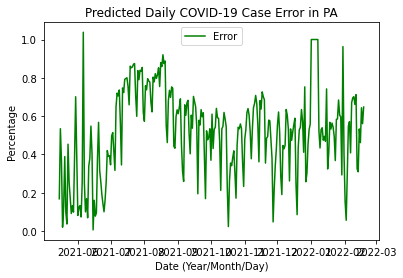

In [29]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

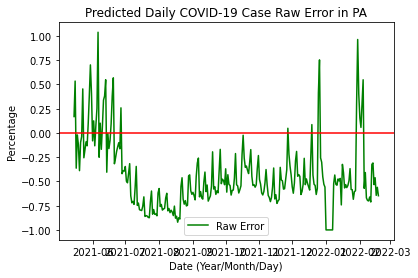

In [30]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

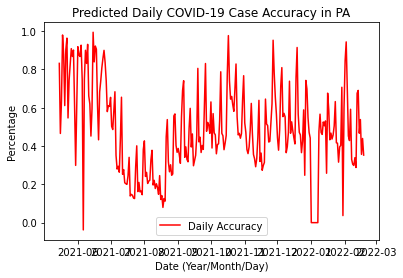

In [31]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [32]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [33]:
len(weeklyDateList)

41

In [35]:
del weeklyDateList[-1:]
len(averageWeeklyAccuracy)

40

In [36]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

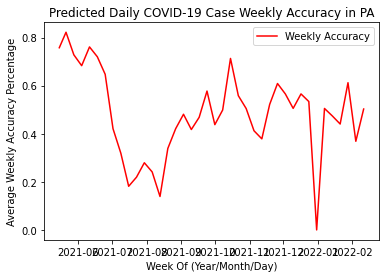

In [37]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [38]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [39]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

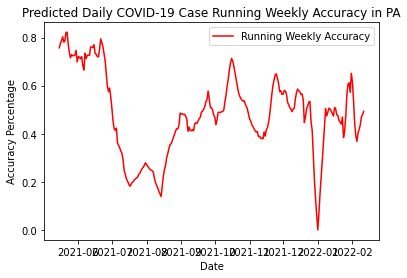

In [40]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

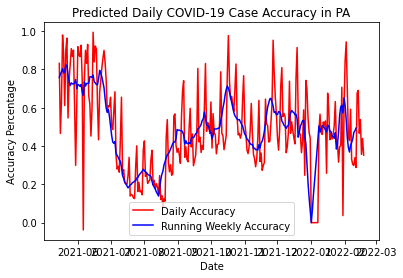

In [41]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [42]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [43]:
del averageMonthlyAccuracy[-1:]
len(averageMonthlyAccuracy)

10

In [44]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])

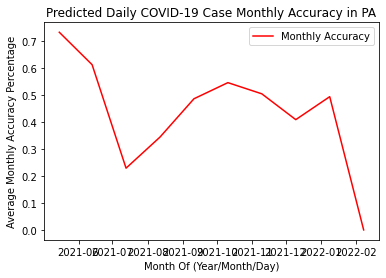

In [45]:
#Create plot of Monthly Accuracy

#Accuracy Line
plt.plot(df['Month Of'], df['Average Monthly Accuracy'], color='r', label='Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Month Of (Year/Month/Day)') 
plt.ylabel('Average Monthly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [46]:
#Calculate Running Monthly Accuracy

runningmonthlyAccuracy = 0
runningAveragemonthlyAccuracy = []
length = len(accuracy)

i = 1
j = 31
#Add first week average
runningAveragemonthlyAccuracy.append(averageMonthlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningmonthlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAveragemonthlyAccuracy.append(runningmonthlyAccuracy / 30)
  runningmonthlyAccuracy = 0

  i += 1
  j += 1

In [47]:
#Create Dataframe for Running Monthly Accuracy
i = 0
data = []
while i < len(runningAveragemonthlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAveragemonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Monthly Average Accuracy'])

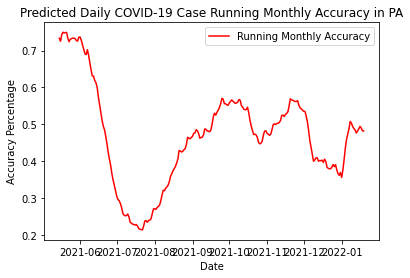

In [48]:
#Create plot of Running Monthly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Monthly Average Accuracy'], color='r', label='Running Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [49]:
#Calculate Yearly Accuracy Averages
#We are going to use an average of 365 days per year for these calculations

yearlyAccuracy = 0
averageYearlyAccuracy = []
amountOfYears = int(length / 365)
remainderDays = length % 365

i = 0
while i < length:
  yearlyAccuracy += accuracy[i]
  if (i + 1) % 365 == 0 and amountOfYears > 0:
    averageYearlyAccuracy.append(yearlyAccuracy / 365)
    amountOfYears -= 1
    yearlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfYears == 0:
    averageYearlyAccuracy.append(yearlyAccuracy / remainderDays)
    yearlyAccuracy = 0
  i += 1

weeklyDateListForYears = []
i = 0
weeklyDateListForYears.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 365 == 0:
    weeklyDateListForYears.append(merged_df_new['Date'][i])
  i += 1

In [50]:
print(averageYearlyAccuracy)

[0.483182208037703]


In [58]:
#Calculate Overall Accuracy
overallAccuracy = merged_df_new['Accuracy'].mean()
print(overallAccuracy)

0.483182208037703


In [59]:
#Create new dataframe for year 2022
data_2022 = merged_df_new[(merged_df_new['Date'] > '2022-01-01')]

In [60]:
#create error and accuracy lists for 2022
error_2022=[]
for index, row in data_2022.iterrows():
  error_2022.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

accuracy_2022 = []
for i in error_2022:
  accuracy_2022.append(1 - i)

In [61]:
#check head of 2022 data
data_2022.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Prediction,Error,Accuracy,RawError
232,2022-01-02,35128,38695.9,4203914,25603978,6449.2,7426.4,1172327.7,2860489,-5275.682283,2774.207671,0.0,1.0,0.0,-1.0
233,2022-01-03,48768,41456.9,4252682,25603978,9816.9,8055.2,1182144.5,2860489,-5275.682283,2774.207671,0.0,1.0,0.0,-1.0
234,2022-01-04,51898,44396.0,4304580,25603978,10744.4,8691.2,1192888.2,2860489,-5275.682283,2774.207671,0.0,1.0,0.0,-1.0
235,2022-01-05,61004,47411.2,4365584,25603978,11662.5,9215.5,1204551.4,2860489,-5275.682283,2774.207671,0.0,1.0,0.0,-1.0
236,2022-01-06,58492,49136.1,4424076,25603978,12854.6,9728.8,1217406.1,2860489,-5275.682283,2774.207671,0.0,1.0,0.0,-1.0


([<matplotlib.axis.XTick at 0x7fade49b1190>,
 <a list of 7 Text major ticklabel objects>)

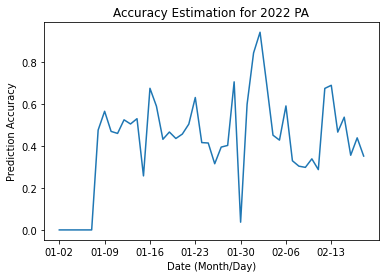

In [62]:
#create plot for 2022 accuracy
plt.xlabel('Date (Month/Day)') 
plt.ylabel('Prediction Accuracy') 
plt.title("Accuracy Estimation for 2022 PA")

plt.plot(data_2022['Date'].dt.strftime('%m-%d'), accuracy_2022, label='Accuracy 2022')
plt.xticks(np.arange(0, len(data_2022['Date']), 7))

In [63]:
#cleans accuracy list of all nan values
newlist = [x for x in accuracy if math.isnan(x) == False]
print(newlist)

[0.8311755132402147, 0.4654696922294843, 0.6364591352839544, 0.9793595934479016, 0.8764135955381712, 0.6109634591270006, 0.9023392502402383, 0.9630208333333333, 0.5463836477987422, 0.743765084473049, 0.8239750445632799, 0.9081532416502947, 0.8672607879924953, 0.9007134363852557, 0.6146725614810722, 0.29877841873091293, 0.5956582633053222, 0.9182234432234432, 0.8756447633998655, 0.8670875129712902, 0.9262154636967231, 0.7462929475587703, -0.03791887125220472, 0.7491895396585261, 0.8995238095238095, 0.8308964525407478, 0.9304227090404196, 0.6615830115830116, 0.61963406052076, 0.4518547750591949, 0.5949347892023051, 0.9936676798378926, 0.8389649272882806, 0.9217575187969925, 0.9054129464285714, 0.6208862712478365, 0.4322895220167714, 0.6818666391228169, 0.7396053464678941, 0.8080269864495055, 0.8571127379627932, 0.899128068255087, 0.8360575486578696, 0.7414187439558952, 0.5794458258024839, 0.6096252958963633, 0.6064666156067449, 0.6538997587268254, 0.502352175159235, 0.4859586653726814, 0

In [64]:
#calculate variance and st deviation of accuracy
var = sum((l-overallAccuracy)**2 for l in newlist) / len(newlist)
st_dev = math.sqrt(var)
print(var)
print(st_dev)

0.05142423150362874
0.22676911496857047


In [65]:
#calculate median of accuracy
accMedian = statistics.median(newlist)
print(accMedian)

0.4635663409467708


In [66]:
#Seperate Running Weekly Average plot into 3 plots for the 3 variants: Original, Delta, Omicron

# Start Date - May 20th 2021
# Delta: May 20th 2021 - December 1st 2021
# Omicron: December 1st 2021 - Present

In [67]:
type(merged_df_new['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [68]:
merged_df_new.index[merged_df_new['Date']=='2021-05-20'].tolist()

[5]

In [69]:
merged_df_new.index[merged_df_new['Date']=='2021-12-01'].tolist()

[200]

In [70]:
#print(merged_inner)
standardVariantDF = merged_df_new[:5]
deltaVariantDF = merged_df_new[5:200]
omicronVariantDF = merged_df_new[200:]

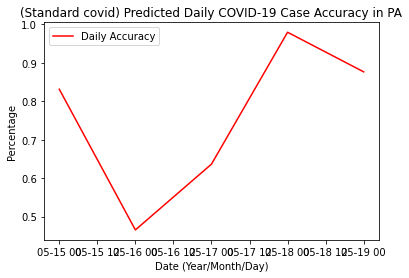

In [71]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(standardVariantDF['Date'], standardVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Standard covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

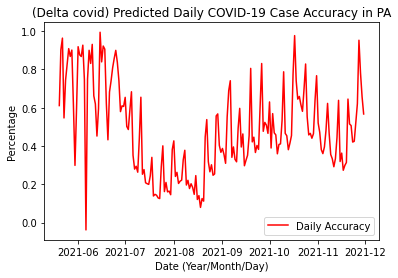

In [72]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(deltaVariantDF['Date'], deltaVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Delta covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

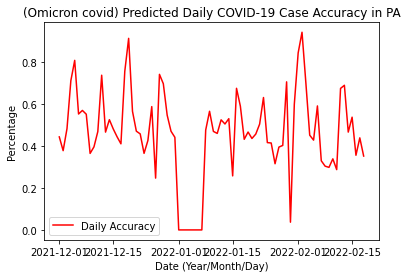

In [73]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(omicronVariantDF['Date'], omicronVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Omicron covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()